# File Organization

This project has been organized into the following directory structure:

## Directory Structure:
- **`Models/`** - Contains all trained model files (.pth)
  - `GAN_Models/` - Generator and Discriminator GAN models
  - `Classifiers/` - Classifier models and best performing models

- **`Generated_Data/`** - Contains synthetic data generated by GANs
  - Generated CSV files for each fault class
  - Augmented datasets for training

- **`Results/`** - Contains evaluation metrics and results
  - Generation results CSV files
  - Training time metrics (.npy files)
  - Discriminator training metrics
  - Performance evaluation results

- **`Plots/`** - Contains all visualization files (.png)
  - Confusion matrix plots
  - FFT comparison plots
  - Time series plots
  - Feature distribution plots

- **`Datasets/`** - Original dataset files
  - CWRU bearing dataset
  - Raw sensor data

## Note:
All file paths in the code have been updated to reflect this new organization. The notebook will automatically save/load files from the appropriate directories.

# Predictive Maintenance using GAN-based Data Augmentation

This notebook implements a complete pipeline for predictive maintenance using GAN-based data augmentation. The code has been cleaned and organized with centralized configuration parameters for easy modification.

## Key Features:
- **Centralized Configuration**: All parameters are defined at the top for easy modification
- **CWRU Dataset Support**: Handles bearing fault diagnosis dataset
- **AC-WGAN Implementation**: Auxiliary Classifier Wasserstein GAN with Temporal Convolutional Networks
- **Data Augmentation**: Generates synthetic samples to balance datasets
- **Comprehensive Evaluation**: Includes FFT comparison, statistical metrics, and classification performance

## How to Use:
1. **Modify Configuration**: Change parameters in the first code cell as needed
2. **Run Sequentially**: Execute cells in order for the complete pipeline
3. **Monitor Results**: Check generated CSV files and plots for evaluation metrics

In [16]:
# ============================================================================
# CONFIGURATION PARAMETERS - Modify these variables as needed
# ============================================================================

import pandas as pd
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt

# Dataset Configuration
path = 'Datasets/CWRU/DE/'
num_classes = 10
percentage = 10  # Percentage of data to use for training samples
fs = 12000  # Sampling frequency

# Model Architecture Configuration
num_blocks = 9  # Number of TCN blocks
nz = 100  # Noise vector length for generator
embed_size = 10  # Label embedding size for generator
channels = 64  # TCN channels
kernel_size = 5  # TCN kernel size
dropout = 0.05  # Dropout rate for TCN

# Training Configuration - GAN
epoch_num = 50 # Number of epochs for GAN training
batch_size = 32
lr = 1e-4  # Learning rate
p_coeff = 10  # Gradient penalty coefficient
n_critic = 5  # Number of D updates per G update
clip_value = 0.01  # Weight clipping value for WGAN
cls_coeff = 1  # Classification loss coefficient
use_wgan_gp = True  # Set to False for WGAN with clipping

# Training Configuration - Classifier
classifier_epochs = 20
classifier_lr = 1e-4

# Data Configuration
seq_len = 1824  # Sequence length
stride_divisor = 50  # Stride = seq_len // stride_divisor
normal_train_samples = 4800  # Training samples for 'N' class
normal_test_samples = 200  # Test samples for 'N' class
faulty_test_samples = 200  # Test samples for faulty classes
validation_samples = 200  # Validation samples per class

# Generation & Evaluation Configuration
num_generated_samples = 100  # Number of samples to generate for evaluation
plot_column = 23  # Column to plot in generated data visualization
fft_freq_limit_divisor = 8  # FFT frequency limit = fs // fft_freq_limit_divisor

# Augmentation Configuration
real_per_class_base = 100  # Base real samples per faulty class
normal_class_samples = 1000  # Real samples for normal class in augmentation
augmentation_configs = [
    {'name': '100', 'fake_per_class': 0},
    {'name': '250', 'fake_per_class': 150},
    {'name': '500', 'fake_per_class': 400},
    {'name': '750', 'fake_per_class': 650},
    {'name': '1000', 'fake_per_class': 900}
]

# Model Selection
use_generator = True  # Whether to use generator for augmentation
evaluation_sample_configs = [100, 500, 1000]  # Sample configurations to evaluate

# Label Mapping - DO NOT CHANGE unless dataset changes
label_mapping = {
    "N": 0, "7BA": 1, "7IR": 2, "7OR1": 3, "14BA": 4, 
    "14IR": 5, "14OR1": 6, "21BA": 7, "21IR": 8, "21OR1": 9
}

# Derived Variables (Calculated from above parameters)
num_train_samples = (4800 * percentage) // 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load CSV files
csv_files = glob.glob(f'{path}*.csv')
dfs = [pd.read_csv(file) for file in csv_files]

print(f"Configuration loaded:")
print(f"  - Dataset path: {path}")
print(f"  - Training samples per faulty class: {num_train_samples}")
print(f"  - Device: {device}")
print(f"  - Number of CSV files found: {len(csv_files)}")

Configuration loaded:
  - Dataset path: Datasets/CWRU/DE/
  - Training samples per faulty class: 480
  - Device: cuda:0
  - Number of CSV files found: 10


#### Time-series Plots

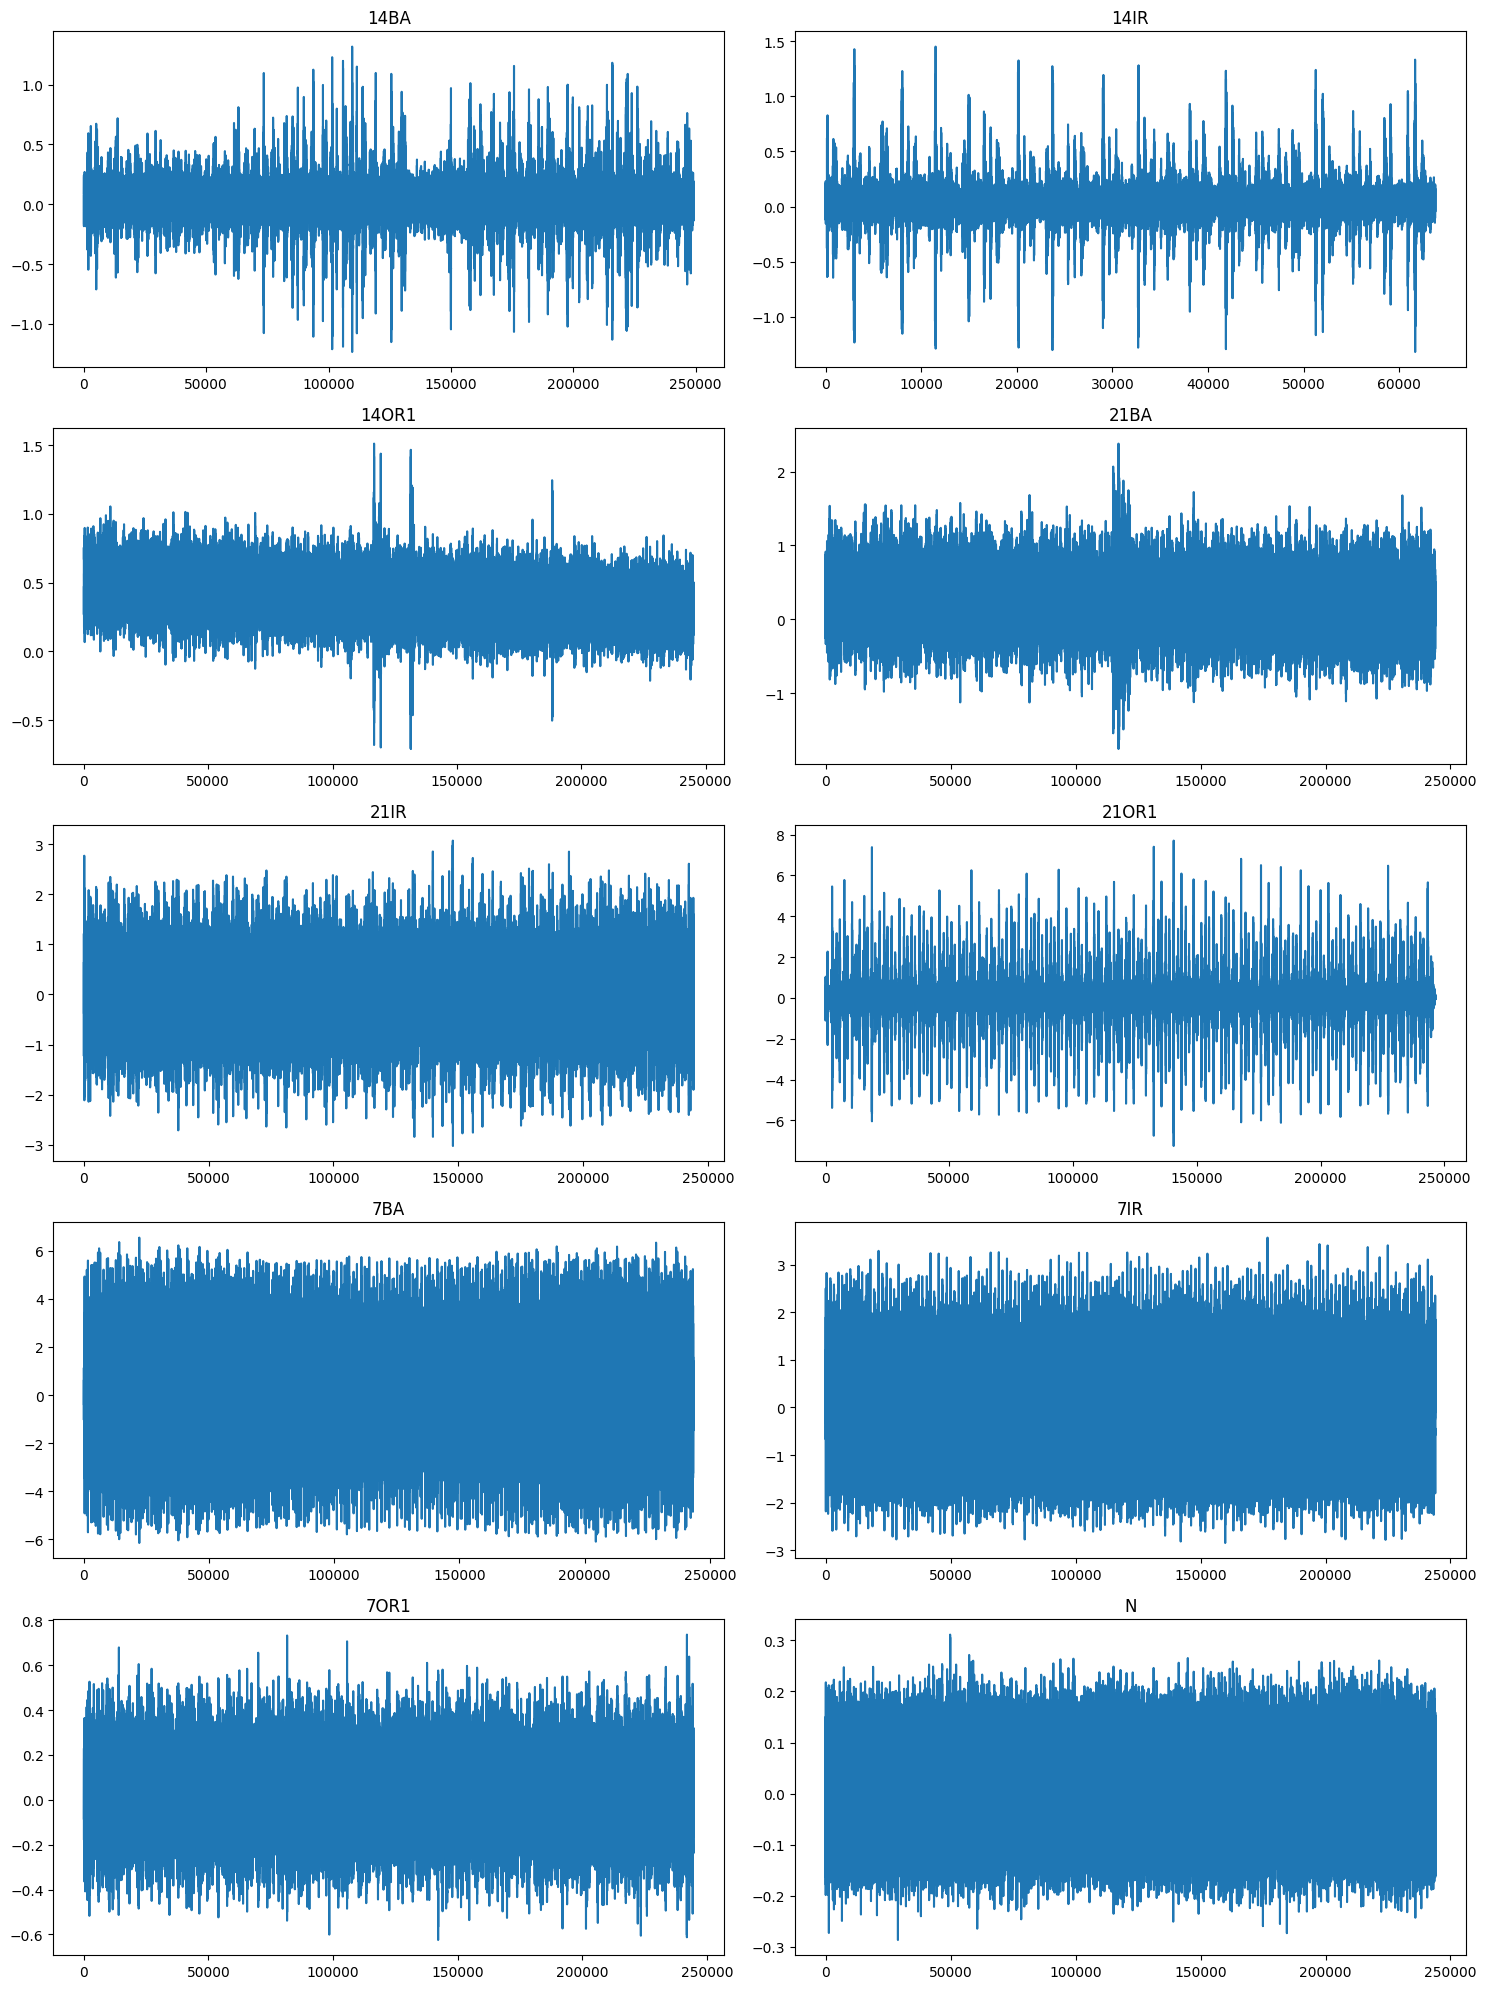

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

axes = axes.flatten()

for i, (df, ax, file) in enumerate(zip(dfs, axes, csv_files)):
    df.plot(ax=ax, legend=False)
    file_name = file.split('\\')[-1].split('.')[0]
    ax.set_title(f'{file_name}')

plt.tight_layout()
plt.show()

### Dataloader

In [18]:
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, ConcatDataset

class SingleCSVDataset(Dataset):
    def __init__(self, file_path, seq_len=seq_len, num_train_samples=num_train_samples, num_test_samples=faulty_test_samples):

        filename = os.path.splitext(os.path.basename(file_path))[0].replace("_Sensor1", "")
        
        label = label_mapping.get(filename, -1)
        if label == -1:
            raise ValueError(f"Label not found for filename: {filename}")

        df = pd.read_csv(file_path, header=None)
        values = df.to_numpy().flatten().astype(np.float32)

        self.min_val = np.min(values)
        self.max_val = np.max(values)
        values = 2 * (values - self.min_val) / (self.max_val - self.min_val + 1e-8) - 1

        self.data = torch.tensor(values, dtype=torch.float32)
        self.seq_len = seq_len

        sequences = self._create_sequences(self.data, seq_len, stride=seq_len // stride_divisor)

        print(f"Number of sequences in {file_path}: {len(sequences)}")

        random.seed(42)
        random.shuffle(sequences)

        if len(sequences) < num_train_samples + num_test_samples:
            raise ValueError(f"Not enough samples in {file_path}. Required: {num_train_samples + num_test_samples}, Found: {len(sequences)}")

        self.train_sequences = sequences[:num_train_samples]
        self.test_sequences = sequences[num_train_samples:num_train_samples + num_test_samples]
        self.valid_sequences = sequences[num_train_samples + num_test_samples:num_train_samples + (2 * num_test_samples)]
        self.label = torch.tensor(label, dtype=torch.long)

    def _create_sequences(self, data, seq_len, stride=None):
        if stride is None:
            stride = seq_len  # Non-overlapping by default
        sequences = [data[i : i + seq_len] for i in range(0, len(data) - seq_len, stride)]
        return sequences

    def __len__(self):
        return len(self.train_sequences) + len(self.test_sequences)

    def __getitem__(self, idx):
        if idx < len(self.train_sequences):
            sequence = self.train_sequences[idx].unsqueeze(0)  # Training sample
        elif idx < len(self.train_sequences) + len(self.test_sequences) and idx >= len(self.train_sequences):
            sequence = self.test_sequences[idx - len(self.train_sequences)].unsqueeze(0)  # Testing sample
        else:
            sequence = self.valid_sequences[idx - len(self.train_sequences) - len(self.test_sequences)].unsqueeze(0)
        return sequence, self.label

In [19]:
# Load train and test data separately
def load_all_data(csv_folder, seq_len=seq_len, num_train_samples=num_train_samples, num_test_samples=faulty_test_samples):
    csv_files = [os.path.join(csv_folder, f) for f in os.listdir(csv_folder) if f.endswith(".csv")]
    train_datasets = []
    test_datasets = []
    valid_datasets = []

    for file_path in csv_files:
        filename = os.path.splitext(os.path.basename(file_path))[0]
        train_samples = num_train_samples if filename[0] != 'N' else normal_train_samples
        test_samples = num_test_samples if filename[0] != 'N' else normal_test_samples
        dataset = SingleCSVDataset(file_path, seq_len, train_samples, test_samples)

        train_datasets.append(torch.utils.data.Subset(dataset, range(train_samples)))
        test_datasets.append(torch.utils.data.Subset(dataset, range(train_samples, train_samples + test_samples)))
        valid_datasets.append(torch.utils.data.Subset(dataset, range(train_samples + test_samples, train_samples + 2 * test_samples)))

    train_data = ConcatDataset(train_datasets)
    test_data = ConcatDataset(test_datasets)
    valid_data = ConcatDataset(valid_datasets)

    return train_data, test_data, valid_data

##### Discriminator & Generator

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GeneratorCNN(nn.Module):
    def __init__(self, nz=nz, num_classes=num_classes, embed_size=embed_size):
        super().__init__()
        
        # Label embedding to create class conditioning
        self.label_emb = nn.Embedding(num_classes, embed_size)

        self.main = nn.Sequential(
            nn.ConvTranspose1d(nz + embed_size, 512, 114, 1, 0, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(True),

            nn.ConvTranspose1d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm1d(256),
            nn.ReLU(True),

            nn.ConvTranspose1d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            nn.ConvTranspose1d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(True),

            nn.ConvTranspose1d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)  # (batch_size, embed_size)
        gen_input = torch.cat((z, label_embedding), dim=1)  # Concatenate label embedding

        gen_input = gen_input.unsqueeze(2)  # Reshape for 1D Conv input
        x = self.main(gen_input)
        x = self.main(gen_input)
        return x
    
# ---------------------------------
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=kernel_size, dilation=1, dropout=dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding="same", dilation=dilation)
        self.norm1 = nn.LayerNorm(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding="same", dilation=dilation)
        self.norm2 = nn.LayerNorm(out_channels)
        self.residual = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x):
        res = self.residual(x)
        x = self.conv1(x)
        x = self.norm1(x.transpose(1,2)).transpose(1,2)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.norm2(x.transpose(1,2)).transpose(1,2)
        x = self.relu(x)
        x = self.dropout(x)
        return x + res

class DiscriminatorTCN(nn.Module):
    def __init__(self, num_classes=num_classes, num_blocks=num_blocks, channels=channels, kernel_size=kernel_size, dropout=dropout):
        super().__init__()
        self.initial_conv = nn.Conv1d(1, channels, kernel_size=1)
        self.tcn_layers = nn.Sequential(*[TCNBlock(channels, channels, kernel_size, dilation=2**i, dropout=dropout) for i in range(num_blocks)])
        self.flatten = nn.AdaptiveAvgPool1d(1)
        self.adv_output = nn.Linear(channels, 1)  # Wasserstein output
        self.classifier = nn.Linear(channels, num_classes)  # Multi-class classification

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.tcn_layers(x)
        x = self.flatten(x).squeeze(2)  # (batch_size, channels)
        validity = self.adv_output(x)  # Wasserstein score
        label_pred = self.classifier(x)  # Class prediction logits
        return validity, label_pred

##### Weight Initialization

In [21]:
### Weight Initialization

import torch.nn as nn

def weights_init(m):
    """ Custom weights initialization """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


##### Training

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.utils.data import DataLoader
import time

torch.backends.cudnn.benchmark = True

losses_D, losses_G, losses_class = [], [], []

Discriminator = DiscriminatorTCN
Generator = GeneratorCNN

def compute_gradient_penalty(netD, real_data, fake_data):
    """ Computes the gradient penalty for WGAN-GP """
    b_size = real_data.size(0)
    
    # Generate random interpolation between real and fake samples
    eps = torch.rand(b_size, 1, 1, device=device)
    interpolates = eps * real_data + (1 - eps) * fake_data
    interpolates.requires_grad_(True)

    # Get discriminator prediction on interpolated data
    d_interpolates, _ = netD(interpolates)
    d_interpolates = d_interpolates.view(-1)  # Flatten to match batch size

    # Compute gradient penalty
    grad_outputs = torch.ones(d_interpolates.shape, device=device)
    gradients = autograd.grad(
        outputs=d_interpolates,  # No `.mean()`, handle shape manually
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(b_size, -1)  # Flatten gradient
    grad_norm = gradients.norm(2, dim=1)  # Compute L2 norm
    gp = p_coeff * ((grad_norm - 1) ** 2).mean()  # Apply penalty
    
    return gp

def train_acwgan(dataloader):
    global losses_D, losses_G, losses_class
    
    # Initialize networks
    netD = Discriminator(num_classes=num_classes, num_blocks=num_blocks).to(device)
    netG = Generator(nz, num_classes=num_classes).to(device)

    # Check if saved models exist and load them
    D_path = os.path.join("Models/GAN_Models", f"{num_train_samples}_wgan-True_{netG.__class__.__name__}-{netD.__class__.__name__}D_{epoch_num}.pth")
    G_path = os.path.join("Models/GAN_Models", f"{num_train_samples}_wgan-True_{netG.__class__.__name__}-{netD.__class__.__name__}G_{epoch_num}.pth")
    
    if os.path.exists(D_path) and os.path.exists(G_path):
        print("Loading saved models...")
        netD.load_state_dict(torch.load(D_path))
        netG.load_state_dict(torch.load(G_path))
    else:
        print("No saved models found. Initializing from scratch...")
        netD.apply(weights_init)
        netG.apply(weights_init)

    # Optimizers
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.9))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.9))

    for epoch in range(epoch_num):
        for step, (real_data, labels) in enumerate(dataloader):
            real_data, labels = real_data.to(device), labels.to(device)
            b_size = real_data.size(0)

            netD.zero_grad()

            # Generate fake data conditioned on labels
            noise = torch.randn(b_size, nz, device=device)
            fake_data = netG(noise, labels).detach()

            # Get Discriminator predictions
            d_real, class_logits_real = netD(real_data)
            d_fake, _ = netD(fake_data)

            # Wasserstein loss for discriminator
            loss_D_wasserstein = torch.mean(d_fake) - torch.mean(d_real)

            # Classification loss
            class_criterion = nn.CrossEntropyLoss()
            loss_D_class = (class_criterion(class_logits_real, labels) * cls_coeff)

            if use_wgan_gp:
                # Gradient penalty
                gp = compute_gradient_penalty(netD, real_data, fake_data)

                # Total Discriminator loss 
                loss_D = loss_D_wasserstein + gp + loss_D_class
            else:
                loss_D = loss_D_wasserstein + loss_D_class
                for p in netD.parameters():
                    p.data.clamp_(-clip_value, clip_value)

            loss_D.backward()
            optimizerD.step()

            if step % n_critic == 0:
                netG.zero_grad()

                # Generate fake samples
                noise = torch.randn(b_size, nz, device=device)
                fake_data = netG(noise, labels)

                # Discriminator output for fake samples
                d_fake, class_logits_fake = netD(fake_data)

                # Generator loss (maximize realness of fake samples)
                loss_G_wasserstein = -torch.mean(d_fake)

                # Generator should produce class-conditioned samples
                loss_G_class = (class_criterion(class_logits_fake, labels) * cls_coeff)

                # Total Generator loss
                loss_G = loss_G_wasserstein + loss_G_class

                loss_G.backward()
                optimizerG.step()

            # Logging losses
            losses_D.append(loss_D.item())
            losses_G.append(loss_G.item())
            losses_class.append(loss_D_class.item())

            if step % 5 == 0:
                if use_wgan_gp:
                    print(f"[Epoch {epoch}/{epoch_num}][Step {step}/{len(dataloader)}] "
                          f"Loss_D: {loss_D.item():.4f} (W: {loss_D_wasserstein.item():.4f}, GP: {gp.item():.4f}, Cls: {loss_D_class.item():.4f}) | "
                          f"Loss_G: {loss_G.item():.4f} (W: {loss_G_wasserstein.item():.4f}, Cls: {loss_G_class.item():.4f})")
                else:
                    print(f"[Epoch {epoch}/{epoch_num}][Step {step}/{len(dataloader)}] "
                          f"Loss_D: {loss_D.item():.4f} (W: {loss_D_wasserstein.item():.4f}, Cls: {loss_D_class.item():.4f}) | "
                          f"Loss_G: {loss_G.item():.4f} (W: {loss_G_wasserstein.item():.4f}, Cls: {loss_G_class.item():.4f})")

        # Save models after every epoch
        torch.save(netG.state_dict(), f"Models/GAN_Models/{num_train_samples}_wgan-{use_wgan_gp}_{netG.__class__.__name__}-{netD.__class__.__name__}G_{epoch_num}.pth") 
        torch.save(netD.state_dict(), f"Models/GAN_Models/{num_train_samples}_wgan-{use_wgan_gp}_{netG.__class__.__name__}-{netD.__class__.__name__}D_{epoch_num}.pth")
        print(f"Epoch {epoch} | Models saved at Models/GAN_Models/")

    return netG, netD  # Return models for further use

# Example usage:
if __name__ == "__main__":
    csv_folder = f"{path}"
    
    # Load dataset and create DataLoader
    train_data, test_data, valid_data = load_all_data(csv_folder, num_train_samples=num_train_samples, num_test_samples=faulty_test_samples)
    
    print(f"Total training samples: {len(train_data)}")
    print(f"Total testing samples: {len(test_data)}")
    print(f"Total validation samples: {len(valid_data)}")

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True) 
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    ''' Training & Save training time'''
    start_time = time.time()

    train_acwgan(train_loader)

    training_time = time.time() - start_time
    np.save(f"Results/{num_train_samples}_training_time.npy", training_time)
    
    ''' Show plots without saving '''
    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(losses_D, label="Discriminator Loss")
    plt.plot(losses_G, label="Generator Loss")
    plt.plot(losses_class, label="Classifier Loss")
    plt.legend()
    plt.xlabel("Steps")
    plt.ylabel("Loss")  
    plt.title("Training Losses")
    plt.show()

Number of sequences in Datasets/CWRU/DE/14BA.csv: 6871
Number of sequences in Datasets/CWRU/DE/14IR.csv: 1722
Number of sequences in Datasets/CWRU/DE/14OR1.csv: 6759
Number of sequences in Datasets/CWRU/DE/21BA.csv: 6726
Number of sequences in Datasets/CWRU/DE/21IR.csv: 6737
Number of sequences in Datasets/CWRU/DE/21OR1.csv: 6793
Number of sequences in Datasets/CWRU/DE/7BA.csv: 6715
Number of sequences in Datasets/CWRU/DE/7IR.csv: 6726
Number of sequences in Datasets/CWRU/DE/7OR1.csv: 6748
Number of sequences in Datasets/CWRU/DE/N.csv: 6726
Total training samples: 9120
Total testing samples: 2000
Total validation samples: 2000


### Validation Scores & FFT Comparison

C:\Users\ROG\AppData\Local\Temp\ipykernel_756\3349434343.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(weight_path, map_location=devic

N: Pearson=0.8530250155165432, Cosine=0.8736500221018282, KL=0.3061134209122746, MMD=0.013866843748956777, P-value=0.646157682862686
Generated samples for N saved to Generated_Data/480_generated_N.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_756\3349434343.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(weight_path, map_location=devic

7BA: Pearson=0.7950948890852362, Cosine=0.8058596520839008, KL=0.44234774320864, MMD=0.0967369584184503, P-value=0.12743097069437928
Generated samples for 7BA saved to Generated_Data/480_generated_7BA.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_756\3349434343.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(weight_path, map_location=devic

7IR: Pearson=0.6896048986929421, Cosine=0.7444648500835356, KL=0.4520873669751023, MMD=0.0846958820074732, P-value=0.08856001507966248
Generated samples for 7IR saved to Generated_Data/480_generated_7IR.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_756\3349434343.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(weight_path, map_location=devic

7OR1: Pearson=0.7718392387572882, Cosine=0.7949880885830248, KL=0.39013046975174326, MMD=0.08934840743042895, P-value=0.253404454074518
Generated samples for 7OR1 saved to Generated_Data/480_generated_7OR1.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_756\3349434343.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(weight_path, map_location=devic

14BA: Pearson=0.7253494096499641, Cosine=0.7591965330659284, KL=0.4878096796556692, MMD=0.06958038774088403, P-value=0.2483781552200956
Generated samples for 14BA saved to Generated_Data/480_generated_14BA.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_756\3349434343.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(weight_path, map_location=devic

14IR: Pearson=0.7643959153921439, Cosine=0.7885849153735353, KL=0.40645325437080204, MMD=0.0652351827250706, P-value=0.19391713446172867
Generated samples for 14IR saved to Generated_Data/480_generated_14IR.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_756\3349434343.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(weight_path, map_location=devic

14OR1: Pearson=0.738873618069073, Cosine=0.7663495729426079, KL=0.4342733864431154, MMD=0.09842102024220517, P-value=0.050999121971369216
Generated samples for 14OR1 saved to Generated_Data/480_generated_14OR1.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_756\3349434343.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(weight_path, map_location=devic

21BA: Pearson=0.7630550090672961, Cosine=0.7825338355590102, KL=0.4016558557608493, MMD=0.0728887943268978, P-value=0.14258401769381193
Generated samples for 21BA saved to Generated_Data/480_generated_21BA.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_756\3349434343.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(weight_path, map_location=devic

21IR: Pearson=0.7733706378705025, Cosine=0.7926141716773111, KL=0.4145428232197008, MMD=0.0982205771765762, P-value=0.1673009305224366
Generated samples for 21IR saved to Generated_Data/480_generated_21IR.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_756\3349434343.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(weight_path, map_location=devic

21OR1: Pearson=0.7016350402721241, Cosine=0.7292946367234683, KL=0.6198434101478414, MMD=0.08069762581875009, P-value=0.27018853130857867
Generated samples for 21OR1 saved to Generated_Data/480_generated_21OR1.csv


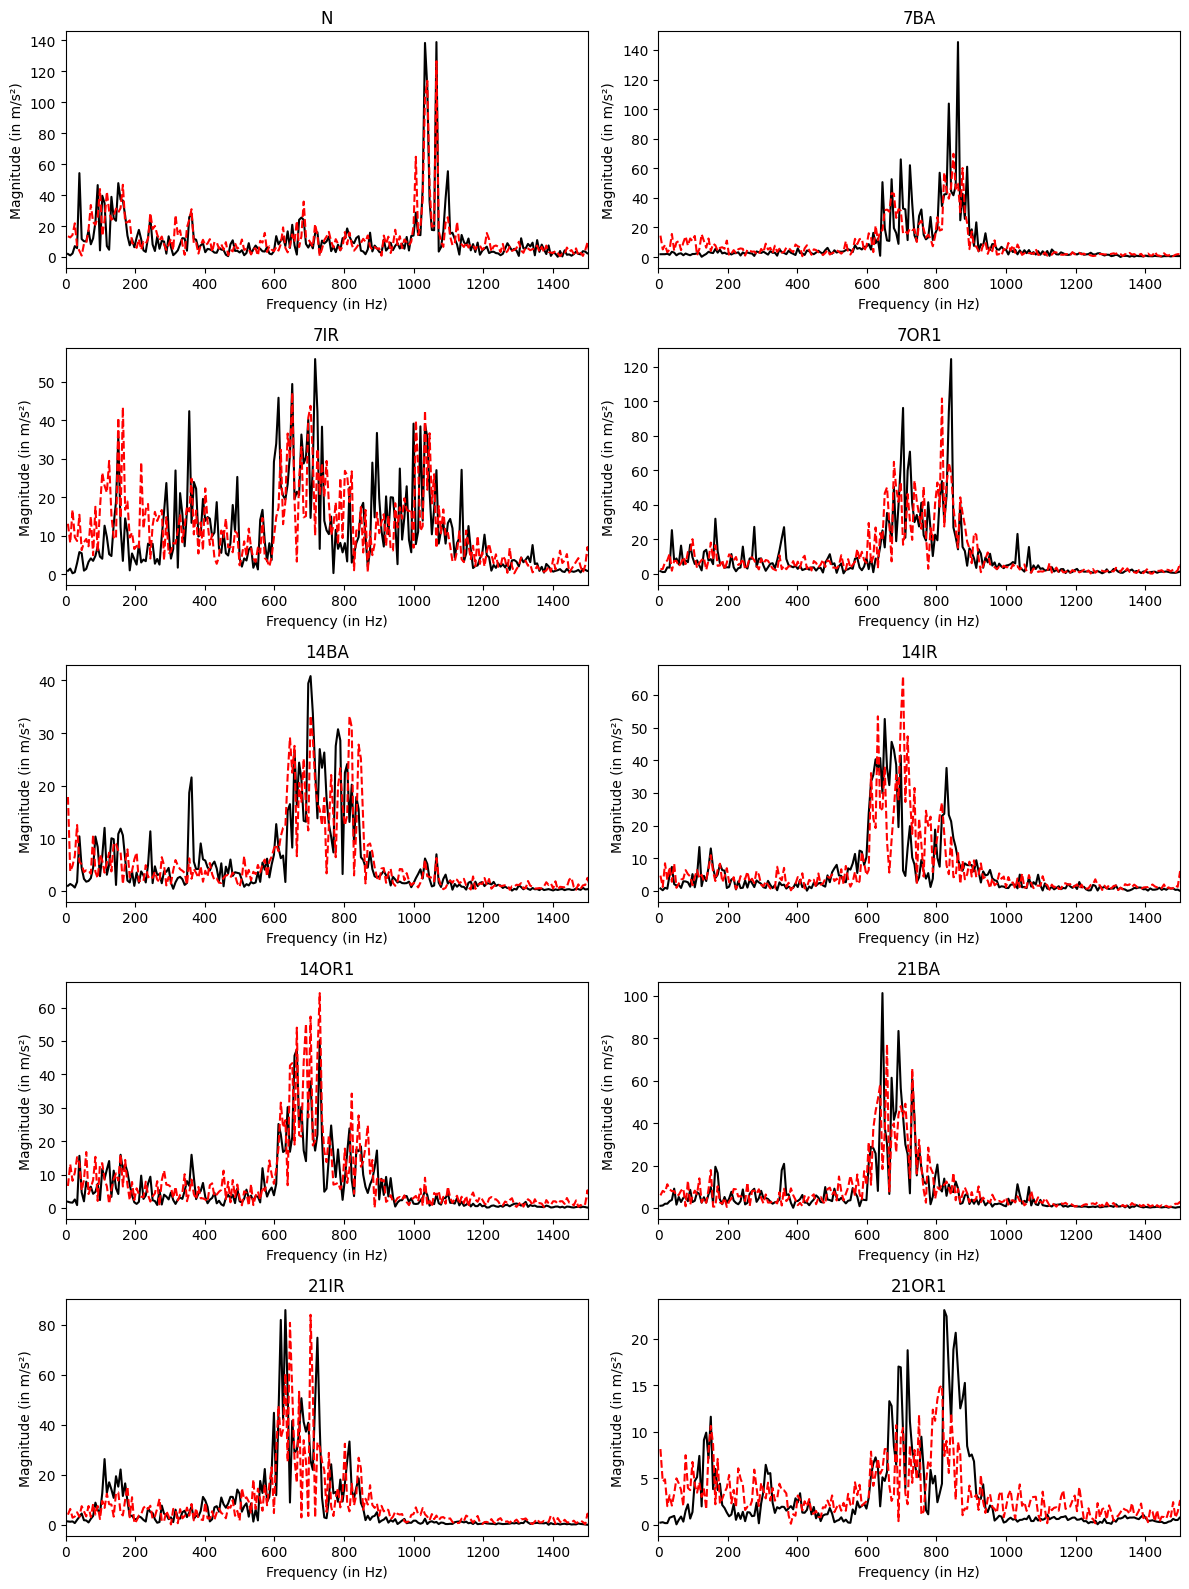

Results stored in Results/480_generation_results.csv


In [26]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, entropy, ttest_ind
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import DataLoader
import csv

# Load and normalize data
def load_data(csv_path):
    values = pd.read_csv(csv_path).values.flatten().astype(np.float32)
    values = 2 * (values - values.min()) / (values.max() - values.min() + 1e-8) - 1
    return values

# Compute FFT
def compute_fft(signal):
    fft_vals = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(fft_vals), d=1/fs)  # Sampling frequency
    pos_idx = freqs > 0
    return np.abs(fft_vals[pos_idx]), freqs[pos_idx]

# Load Generator Model
def load_generator(GeneratorModel, num_classes, weight_path, nz=nz, device='cpu'):
    netG = GeneratorModel(nz, num_classes=num_classes).to(device)
    netG.load_state_dict(torch.load(weight_path, map_location=device))
    netG.eval()
    return netG

# Generate synthetic sequences
def generate_sequences(generator, label, n_samples=1, nz=nz, device='cpu'):
    noise = torch.randn(n_samples, nz, device=device)  # Generate n_samples random noise vectors
    label_tensor = torch.full((n_samples,), label, dtype=torch.long, device=device)  # Set class label for all
    with torch.no_grad():
        return generator(noise, label_tensor).cpu().numpy().squeeze()

# Compute MMD
def compute_mmd(x, y, sigma=1.0):
    x, y = torch.tensor(x).unsqueeze(1), torch.tensor(y).unsqueeze(1)
    kernel = lambda a, b: torch.exp(-((a - b.T) ** 2) / (2 * sigma ** 2))
    return kernel(x, x).mean() + kernel(y, y).mean() - 2 * kernel(x, y).mean()

# Compute all metrics
def compute_metrics(original, generated):
    pearson_corr, _ = pearsonr(original, generated)
    cosine_sim = cosine_similarity(original.reshape(1, -1), generated.reshape(1, -1))[0][0]
    kl_div = entropy(original / original.sum(), generated / generated.sum())
    mmd_val = compute_mmd(original, generated).item()
    t_stat, p_value = ttest_ind(original, generated)
    return pearson_corr, cosine_sim, kl_div, mmd_val, t_stat, p_value

def plot_ffts_all(original_freqs, original_mags, generated_freqs, generated_mags, titles):
    plt.figure(figsize=(12, 16))  # Adjust the figure size for better visibility
    for i in range(num_classes):
        plt.subplot(5, 2, i + 1)  # 4 rows, 2 columns
        plt.plot(original_freqs[i], original_mags[i], label="Original FFT", color='black')
        plt.plot(generated_freqs[i], generated_mags[i], label="Generated FFT", color='red', linestyle='--')
        plt.title(titles[i].replace("_Sensor", "").replace("30hz", ""))
        plt.xlabel("Frequency (in Hz)")
        plt.xlim(0, fs // fft_freq_limit_divisor)
        plt.ylabel("Magnitude (in m/s²)")
        # plt.legend()
    plt.tight_layout()
    plt.show()

# Main execution
weight_path = f'./Models/GAN_Models/{num_train_samples}_wgan-True_GeneratorCNN-DiscriminatorTCNG_{epoch_num}.pth'

GeneratorModel = GeneratorCNN

# Define CSV file path
results_csv_path = f"Results/{num_train_samples}_generation_results.csv"

original_freqs_all, original_mags_all, generated_freqs_all, generated_mags_all = [], [], [], []

# Open CSV file and write header
with open(results_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Test Name", "Avg Pearson", "Avg Cosine", "Avg KL", "Avg MMD", "Avg GAN-Test P-value"])

    for file_name, label_value in label_mapping.items():
        pearson_corrs, cosine_sims, kl_divs, mmd_vals, p_values = [], [], [], [], []
        generated_samples = []

        # Ensure different generated samples by using different noise each time
        generator = load_generator(GeneratorModel, num_classes, weight_path, device=device)
        for _ in range(num_generated_samples):
            indexes = [idx for idx, (_, label) in enumerate(test_data) if label == label_value]
            random_index = np.random.choice(indexes)
            original_signal = test_data[random_index][0].numpy().flatten()
            original_mag, original_freq = compute_fft(original_signal)

            # Generate a different sample each time by using new noise
            generated_signal = generate_sequences(generator, label_value, n_samples=1, device=device)
            if generated_signal.ndim > 1:
                generated_signal = generated_signal[0]
            generated_samples.append(generated_signal)
            generated_mag, generated_freq = compute_fft(generated_signal)

            pearson_corr, cosine_sim, kl_div, mmd_val, _, p_value = compute_metrics(original_mag, generated_mag)
            pearson_corrs.append(pearson_corr)
            cosine_sims.append(cosine_sim)
            kl_divs.append(kl_div)
            mmd_vals.append(mmd_val)
            p_values.append(p_value)
        
        avg_pearson = np.mean(pearson_corrs)
        avg_cosine = np.mean(cosine_sims)
        avg_kl = np.mean(kl_divs)
        avg_mmd = np.mean(mmd_vals)
        avg_p_value = np.mean(p_values)
        
        writer.writerow([file_name, avg_pearson, avg_cosine, avg_kl, avg_mmd, avg_p_value])

        print(f"{file_name}: Pearson={avg_pearson}, Cosine={avg_cosine}, KL={avg_kl}, MMD={avg_mmd}, P-value={avg_p_value}") 
        original_freqs_all.append(original_freq)  
        original_mags_all.append(original_mag)
        generated_freqs_all.append(generated_freq)
        generated_mags_all.append(generated_mag)

        # Save generated samples for this class to a CSV (each column is a sample)
        generated_samples_arr = np.stack(generated_samples, axis=1) 
        gen_csv_path = f"Generated_Data/{num_train_samples}_generated_{file_name}.csv"
        np.savetxt(gen_csv_path, generated_samples_arr, delimiter=",")
        print(f"Generated samples for {file_name} saved to {gen_csv_path}")

plot_ffts_all(original_freqs_all, original_mags_all, generated_freqs_all, generated_mags_all, list(label_mapping.keys()))
print(f"Results stored in {results_csv_path}")

#### VISUALIZE GENERATED DATA

1824


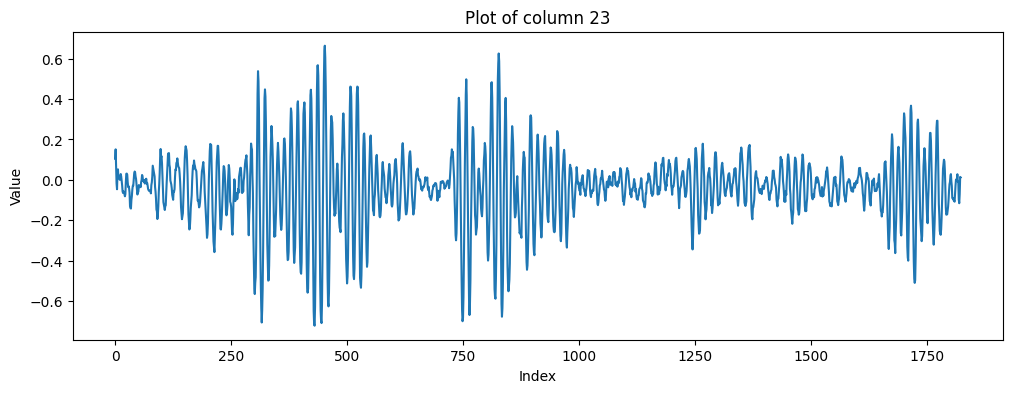

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

csv_file = f'Generated_Data/{num_train_samples}_generated_7BA.csv'  # Uses configuration variable

df = pd.read_csv(csv_file, header=None)
col = plot_column  # Uses configuration variable

print(len(df)) 
plt.figure(figsize=(12, 4))
plt.plot(df.iloc[:, col])
plt.title(f"Plot of column {col}")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

#### CLASSIFICATION

In [28]:
# Load train and test data separately
def load_all_data_classifier(csv_folder, seq_len=seq_len, num_train_samples=real_per_class_base, num_test_samples=faulty_test_samples):
    csv_files = [os.path.join(csv_folder, f) for f in os.listdir(csv_folder) if f.endswith(".csv")]
    train_datasets = []
    test_datasets = []
    valid_datasets = []

    for file_path in csv_files:
        filename = os.path.splitext(os.path.basename(file_path))[0]
        train_samples = num_train_samples if filename[0] != 'N' else normal_class_samples
        test_samples = num_test_samples if filename[0] != 'N' else normal_test_samples
        dataset = SingleCSVDataset(file_path, seq_len, train_samples, test_samples)

        train_datasets.append(torch.utils.data.Subset(dataset, range(train_samples)))
        test_datasets.append(torch.utils.data.Subset(dataset, range(train_samples, train_samples + test_samples)))
        valid_datasets.append(torch.utils.data.Subset(dataset, range(train_samples + test_samples, train_samples + 2 * test_samples)))

    train_data = ConcatDataset(train_datasets)
    test_data = ConcatDataset(test_datasets)
    valid_data = ConcatDataset(valid_datasets)

    return train_data, test_data, valid_data

In [37]:
# Use centralized configuration
weight_path = f'./Models/GAN_Models/{num_train_samples}_wgan-True_GeneratorCNN-DiscriminatorTCNG_{epoch_num}.pth'

GeneratorModel = GeneratorCNN

In [38]:
train_data, test_data, valid_data = load_all_data_classifier(path, num_train_samples=real_per_class_base, num_test_samples=faulty_test_samples)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True) 
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

Number of sequences in Datasets/CWRU/DE/14BA.csv: 6871
Number of sequences in Datasets/CWRU/DE/14IR.csv: 1722
Number of sequences in Datasets/CWRU/DE/14OR1.csv: 6759
Number of sequences in Datasets/CWRU/DE/21BA.csv: 6726
Number of sequences in Datasets/CWRU/DE/21IR.csv: 6737
Number of sequences in Datasets/CWRU/DE/21OR1.csv: 6793
Number of sequences in Datasets/CWRU/DE/7BA.csv: 6715
Number of sequences in Datasets/CWRU/DE/7IR.csv: 6726
Number of sequences in Datasets/CWRU/DE/7OR1.csv: 6748
Number of sequences in Datasets/CWRU/DE/N.csv: 6726


In [39]:
# Load trained generator for augmentation
if use_generator:
    try:
        generator = load_generator(GeneratorModel, num_classes, weight_path, nz=nz, device=device)
        print(f"Generator loaded successfully from {weight_path}")
    except FileNotFoundError:
        print(f"Warning: Generator model not found at {weight_path}")
        print("Please train the GAN first or set use_generator=False")
        generator = None
else:
    generator = None
    print("Generator usage disabled in configuration")

Generator loaded successfully from ./Models/GAN_Models/480_wgan-True_GeneratorCNN-DiscriminatorTCNG_50.pth


C:\Users\ROG\AppData\Local\Temp\ipykernel_756\3349434343.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(weight_path, map_location=devic

#### AUGMENTATION

In [40]:
class CombinedDataset(Dataset):
    def __init__(self, real_dataset, generator, num_classes, nz=nz, 
                 real_per_class=real_per_class_base, fake_per_class=0, device='cpu'):
        self.device = device
        self.generator = generator
        self.nz = nz
        self.num_classes = num_classes

        label_to_samples = {i: [] for i in range(num_classes)}
        for sample, label in real_dataset:
            label_to_samples[label.item()].append((sample, label))

        self.real_data = []
        for label in range(num_classes):
            if label == 0:  # Skip label 0
                real_per_class_adjusted = normal_class_samples
            else:
                real_per_class_adjusted = real_per_class
            samples = label_to_samples[label][:real_per_class_adjusted]
            self.real_data.extend(samples)

        self.fake_data = []
        if generator is not None and fake_per_class > 0:
            for label in range(num_classes):
                if label == 0:  # Skip label 0
                    continue
                for _ in range(fake_per_class):
                    noise = torch.randn(1, self.nz, device=self.device)
                    label_tensor = torch.tensor([label], dtype=torch.long, device=self.device)
                    with torch.no_grad():
                        generated = self.generator(noise, label_tensor).cpu().numpy().flatten()
                    sequence_tensor = torch.tensor(generated, dtype=torch.float32).unsqueeze(0)
                    self.fake_data.append((sequence_tensor, torch.tensor(label)))

        # Merge real and fake data
        self.all_data = self.real_data + self.fake_data

    def __len__(self):
        return len(self.all_data)

    def __getitem__(self, idx):
        return self.all_data[idx]

# Create datasets using configuration
custom_datasets = {}
custom_loaders = {}

if generator is not None:
    for config in augmentation_configs:
        dataset_name = f"custom_dataset_{config['name']}"
        loader_name = f"custom_loader_{config['name']}"
        
        custom_datasets[config['name']] = CombinedDataset(
            real_dataset=train_data,
            generator=generator,
            num_classes=num_classes,
            nz=nz,
            real_per_class=real_per_class_base,
            fake_per_class=config['fake_per_class'],
            device=device
        )
        
        custom_loaders[config['name']] = DataLoader(custom_datasets[config['name']], batch_size=batch_size, shuffle=True)

    from collections import Counter

    # Print label distributions for each configuration
    for config_name, dataset in custom_datasets.items():
        label_counts = Counter()
        for _, label in dataset:
            label_counts[int(label)] += 1
        print(f"Label distribution for {config_name}:")
        print(label_counts)
else:
    print("Warning: Generator not available. Cannot create augmented datasets.")
    print("Please train the GAN first or check the model path.")

Label distribution for 100:
Counter({0: 1000, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100})
Label distribution for 250:
Counter({0: 1000, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250, 7: 250, 8: 250, 9: 250})
Label distribution for 500:
Counter({0: 1000, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500})
Label distribution for 750:
Counter({0: 1000, 1: 750, 2: 750, 3: 750, 4: 750, 5: 750, 6: 750, 7: 750, 8: 750, 9: 750})
Label distribution for 1000:
Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000})


#### TRAIN CLASSIFIER ON AUGMENTED DATASET

In [ ]:
import torch
import torch.nn as nn
import csv

# Optional: Custom weight initialization
def initialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, (nn.Conv1d, nn.Linear)):
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

def evaluate_model(discriminator, val_loader, criterion, device):
    discriminator.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            _, class_logits = discriminator(data)
            loss = criterion(class_logits, labels)
            val_loss += loss.item()
            predictions = torch.argmax(class_logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    return val_loss, accuracy

def train_discriminator(discriminator, train_loader, val_loader, optimizer, criterion, device='cpu', epochs=classifier_epochs, samples=100):
    discriminator.train()
    train_losses = []
    val_accuracies = []
    best_val_accuracy = 0.0
    best_model_state = None

    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        discriminator.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            _, class_logits = discriminator(data)
            loss = criterion(class_logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predictions = torch.argmax(class_logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total * 100
        train_losses.append(total_loss)

        # Evaluate on validation set
        val_loss, val_accuracy = evaluate_model(discriminator, val_loader, criterion, device)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {total_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")

        # Save the best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = discriminator.state_dict()

    torch.save(best_model_state, f"Models/Classifiers/{classifier_epochs}_discriminator_model_{samples}_{epochs}.pth")

    # Save training metrics
    with open(f"Results/discriminator_training_metrics_{samples}.csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Val Accuracy"])
        for epoch, (loss, acc) in enumerate(zip(train_losses, val_accuracies), 1):
            writer.writerow([epoch, loss, acc])

    return train_losses, val_accuracies

def build_and_train_discriminator(train_loader, val_loader, num_classes, num_blocks, device, epochs, samples):
    discriminator = DiscriminatorTCN(num_classes=num_classes, num_blocks=num_blocks).to(device)
    initialize_weights(discriminator)
    optimizer = torch.optim.Adam(discriminator.parameters(), lr=classifier_lr, betas=(0.5, 0.9))
    criterion = nn.CrossEntropyLoss()
    return train_discriminator(discriminator, train_loader, val_loader, optimizer, criterion, device=device, epochs=epochs, samples=samples)

if __name__ == "__main__":
    # Train classifiers for different sample configurations
    if 'custom_loaders' in globals() and len(custom_loaders) > 0:
        results = {}
        for config in augmentation_configs:
            if config['name'] in ['100', '500', '1000'] and config['name'] in custom_loaders:  # Only train selected configurations
                config_name = config['name']
                print(f"\nTraining classifier for {config_name} samples...")
                
                losses, val_accuracies = build_and_train_discriminator(
                    custom_loaders[config_name], 
                    val_loader, 
                    num_classes, 
                    num_blocks, 
                    device, 
                    epochs=classifier_epochs, 
                    samples=int(config_name)
                )
                results[config_name] = {'losses': losses, 'val_accuracies': val_accuracies}
    else:
        print("Warning: Custom loaders not available. Cannot train classifiers.")
        print("Please ensure the generator is loaded and datasets are created first.")


Training classifier for 100 samples...
Epoch [1/20] - Train Loss: 98.5975, Train Acc: 55.21%, Val Acc: 42.70%
Epoch [2/20] - Train Loss: 45.1856, Train Acc: 77.11%, Val Acc: 72.95%
Epoch [3/20] - Train Loss: 29.4861, Train Acc: 86.47%, Val Acc: 80.30%
Epoch [4/20] - Train Loss: 19.4183, Train Acc: 92.16%, Val Acc: 83.25%
Epoch [5/20] - Train Loss: 13.8219, Train Acc: 94.42%, Val Acc: 88.95%
Epoch [6/20] - Train Loss: 9.7965, Train Acc: 96.32%, Val Acc: 78.15%
Epoch [7/20] - Train Loss: 8.1013, Train Acc: 96.63%, Val Acc: 92.35%
Epoch [8/20] - Train Loss: 6.3611, Train Acc: 97.63%, Val Acc: 79.15%
Epoch [9/20] - Train Loss: 5.2467, Train Acc: 97.74%, Val Acc: 89.00%
Epoch [10/20] - Train Loss: 4.8767, Train Acc: 97.68%, Val Acc: 96.65%
Epoch [11/20] - Train Loss: 4.3831, Train Acc: 98.32%, Val Acc: 94.10%
Epoch [12/20] - Train Loss: 3.7564, Train Acc: 98.05%, Val Acc: 96.80%
Epoch [13/20] - Train Loss: 3.8086, Train Acc: 97.95%, Val Acc: 95.40%
Epoch [14/20] - Train Loss: 3.1797, Train


Evaluating model trained on 100 samples


C:\Users\ROG\AppData\Local\Temp\ipykernel_756\2826939739.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netD.load_state_dict(torch.load(weight_path, map_location=devic

Label counts: {4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200, 1: 200, 2: 200, 3: 200, 0: 200}
dict_keys([4, 5, 6, 7, 8, 9, 1, 2, 3, 0])


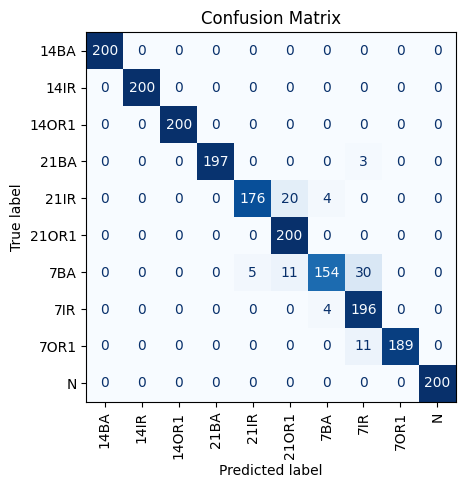

Classification Accuracy: 95.60%
Precision: 0.96
Recall (Sensitivity): 0.96
F1-Score: 0.96
Specificity: 0.96

Evaluating model trained on 500 samples


C:\Users\ROG\AppData\Local\Temp\ipykernel_756\2826939739.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netD.load_state_dict(torch.load(weight_path, map_location=devic

Label counts: {4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200, 1: 200, 2: 200, 3: 200, 0: 200}
dict_keys([4, 5, 6, 7, 8, 9, 1, 2, 3, 0])


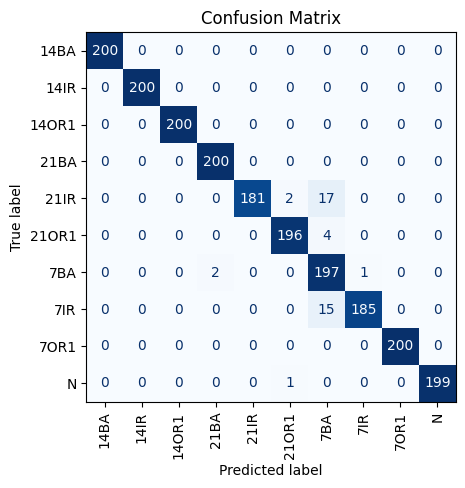

Classification Accuracy: 97.90%
Precision: 0.98
Recall (Sensitivity): 0.98
F1-Score: 0.98
Specificity: 0.98

Evaluating model trained on 1000 samples


C:\Users\ROG\AppData\Local\Temp\ipykernel_756\2826939739.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netD.load_state_dict(torch.load(weight_path, map_location=devic

Label counts: {4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200, 1: 200, 2: 200, 3: 200, 0: 200}
dict_keys([4, 5, 6, 7, 8, 9, 1, 2, 3, 0])


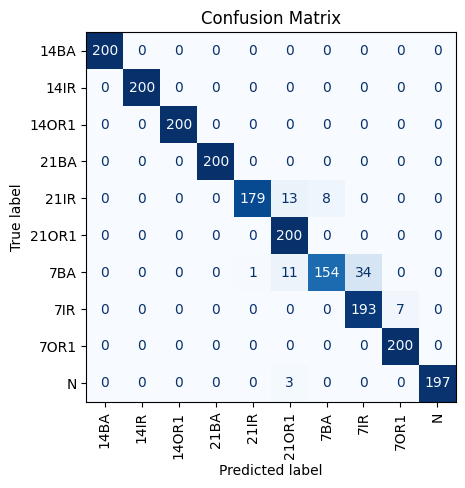

Classification Accuracy: 96.15%
Precision: 0.96
Recall (Sensitivity): 0.96
F1-Score: 0.96
Specificity: 0.96


In [45]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Function to filter the data loader based on target labels
def filter_data_loader(data_loader, target_labels, device='cpu'):
    filtered_data = []
    for data, labels in data_loader:
        mask = torch.tensor([label in target_labels for label in labels], dtype=torch.bool, device=device)
        filtered_data.extend([(data[i], labels[i]) for i in range(len(labels)) if mask[i]])
    return DataLoader(filtered_data, batch_size=data_loader.batch_size, shuffle=False)

# Modify this function to return the confusion matrix instead of plotting
def calculate_metrics_for_labels(discriminator, data_loader, target_labels, label_mapping, device='cpu'):
    filtered_loader = filter_data_loader(data_loader, target_labels, device)
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data, labels in filtered_loader:
            data = data.to(device)  # Move input data to the same device as the model
            _, class_logits = discriminator(data)
            predictions = torch.argmax(class_logits, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_predictions, labels=target_labels, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, labels=target_labels, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, labels=target_labels, average='weighted', zero_division=0)
    sensitivity = recall  # Sensitivity is equivalent to recall
    cm = confusion_matrix(all_labels, all_predictions, labels=target_labels)
    specificity = np.mean([cm[i, i] / (cm[:, i].sum() + 1e-8) for i in range(len(cm))])

    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    label_names = [reverse_label_mapping[i] for i in target_labels]

    return precision, recall, f1, sensitivity, specificity, cm, label_names

def load_discriminator(DiscriminatorModel, weight_path, num_classes, num_blocks, device='cpu'):
    # Initialize the discriminator model and load pre-trained weights
    netD = DiscriminatorModel(num_classes, num_blocks).to(device)
    netD.load_state_dict(torch.load(weight_path, map_location=device))
    netD.eval()  # Set the model to evaluation mode
    return netD

def calculate_accuracy(discriminator, data_loader, device='cpu'):
    correct = 0  # Counter for correct predictions
    total = 0  # Counter for total samples

    with torch.no_grad():  # Disable gradient computation for evaluation
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            _, class_logits = discriminator(data)  
            predictions = torch.argmax(class_logits, dim=1) 
            correct += (predictions == labels).sum().item() 
            total += labels.size(0)  

    accuracy = correct / total * 100  
    return accuracy

# Calculate classification metrics
def calculate_metrics(discriminator, data_loader, device='cpu'):
    all_labels = []  
    all_predictions = []  
    label_counts = {} 

    # Count occurrences of each label in the dataset
    for _, labels in data_loader:
        for label in labels:
            label = label.item()
            label_counts[label] = label_counts.get(label, 0) + 1
    print(f"Label counts: {label_counts}")

    with torch.no_grad(): 
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            _, class_logits = discriminator(data) 
            predictions = torch.argmax(class_logits, dim=1) 
            all_labels.extend(labels.cpu().numpy()) 
            all_predictions.extend(predictions.cpu().numpy())

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    sensitivity = recall  # Sensitivity is equivalent to recall in this context

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Reverse the label mapping for display
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    print(label_counts.keys())
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[reverse_label_mapping[i] for i in label_counts.keys()])
    specificity = np.mean([cm[i, i] / (cm[:, i].sum() + 1e-8) for i in range(len(cm))])  # Calculate specificity
    disp.plot(cmap='Blues', xticks_rotation='vertical', colorbar=False)  # Removed the colorbar (side bar)
    plt.title("Confusion Matrix")
    plt.show()

    return precision, recall, f1, sensitivity, specificity

# Evaluate models for different sample configurations
for num_samples in evaluation_sample_configs:
    print(f"\n{'='*50}")
    print(f"Evaluating model trained on {num_samples} samples")
    print(f"{'='*50}")

    weight_path = f'./Models/Classifiers/{classifier_epochs}_discriminator_model_{num_samples}_{classifier_epochs}.pth'

    loader = test_loader  

    Discriminator = DiscriminatorTCN

    # Load the discriminator
    discriminator = load_discriminator(Discriminator, weight_path, num_classes=num_classes, num_blocks=num_blocks, device=device)

    # Calculate accuracy on the test dataset
    accuracy = calculate_accuracy(discriminator, loader, device=device)

    # Calculate metrics
    precision, recall, f1, sensitivity, specificity = calculate_metrics(discriminator, loader, device=device)

    # Print metrics
    print(f"Classification Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"Specificity: {specificity:.2f}")